# Part 2: Power spectra, halo bias, and cosmic voids
In this second part, we will discuss mass assignment schemes and demonstrate how to compute power spectra with ``Pylians``. We will also illustrate the principles of halo bias. Finally, we conclude with a section on the analysis of cosmic voids.

## Pylians and mass interpolation

We will use the ``Pylians`` library to construct density fields and compute power spectra.

In [1]:
import numpy as np
import MAS_library as MASL

import readsnap,readgadget

In [2]:
# The same downsampled FLAMINGO snapshot we used before
snapshot = "flamingo_0077"  #snapshot name

# Read the snapshot (we can use functions for Gadget, because the SWIFT format is compatible with Gadget)
head = readgadget.header(snapshot)

BoxSize = head.boxsize[0] # Mpc

# Read the DM particle positions and masses
pos = readgadget.read_field(snapshot, "POS ", 1)
mas = readgadget.read_field(snapshot, "MASS", 1)


To construct a density grid, we can use different mass assignment or interpolation schemes. Beyond simply assigning each particle to the nearest grid cell, the simplest and most common approach is known as **Cloud-in-Cell (CIC)**. This amounts to linear interpolation to 27 nearest cells.

In [3]:
# Create an empty cubic grid
grid = 512
density = np.zeros((grid, grid, grid), dtype=np.float32)

# Do the mass interpolation, using the Cloud-in-Cell scheme
MAS = 'CIC'
MASL.MA(pos, density, BoxSize, MAS, W=mas)

# Compute the density contrast
delta = density / np.mean(density, dtype=np.float64) - 1.0
delta = delta.astype(np.float32)

/tmp/ipykernel_3340892/4013656575.py:8: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(1+delta[256-15:256+15].mean(axis=0)), cmap=cmap, vmin=-3)


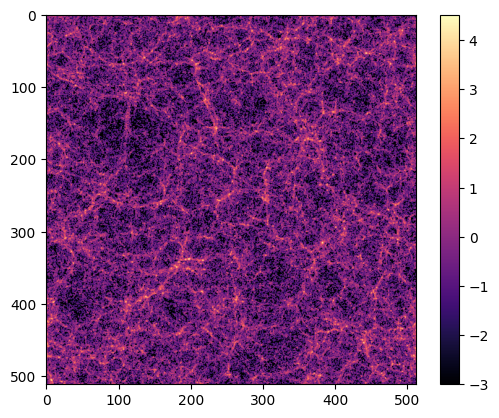

In [4]:
from matplotlib import pyplot as plt
from matplotlib.cm import magma

cmap = magma
cmap.set_bad('black',1.)

# Plot the density field
plt.imshow(np.log(1+delta[256-15:256+15].mean(axis=0)), cmap=cmap, vmin=-3)
plt.colorbar()

## Power spectra
The power spectrum is a powerful diagnostic that captures the average variance in the density field on a length scale $k$. It can be defined in Fourier space as $P(k)=\langle\delta(\mathbf{k})\delta^*(\mathbf{k})\rangle$, where $\delta(\mathbf{k})$ is the Fourier transform of the density contrast $\delta(\mathbf{x})$. The power spectrum is also the Fourier transform of the correlation function, $\xi(r)$, which counts the number of pairs at a given distance $r$.

In [5]:
import Pk_library as PKL

# We can ignore the axis, because we are not including redshift space distortions
axis = 0

# Compute power spectrum
threads = 1
verbose = True
Pk_results = PKL.Pk(delta, BoxSize, axis, MAS, threads, verbose)

# Extract the 3D power spectrum
k = Pk_results.k3D
Pk = Pk_results.Pk[:,0] #monopole
Nmodes = Pk_results.Nmodes3D



Computing power spectrum of the field...
Time to complete loop = 5.39
Time taken = 9.90 seconds


Text(0, 0.5, '$P_\\mathrm{c}(k)$ (Mpc^3)')

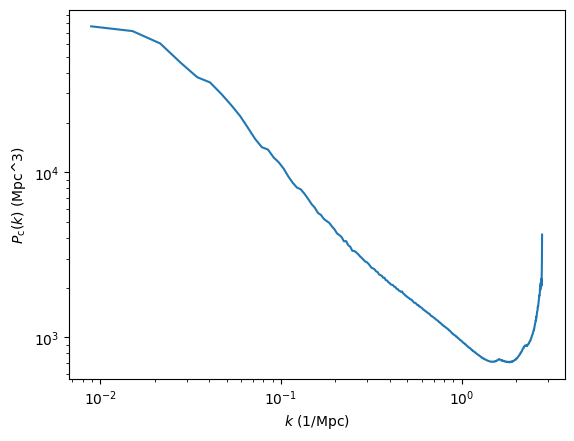

In [6]:
# Plot the CDM power spectrum
plt.loglog(k, Pk)
plt.xlabel("$k$ (1/Mpc)")
plt.ylabel("$P_\\mathrm{c}(k)$ (Mpc^3)")

The upturn on small scales is an artefact of the limited resolution.

## Halo bias
You may know that galaxies and dark matter halos are biased tracers of the dark matter. This means that galaxies and halos are more strongly clustered around density peaks than the dark matter. Mathematically, we can express this as

$$\delta_\mathrm{h} = b\delta_\mathrm{c},$$

where $b$ is the linear bias, $\delta_\mathrm{h}=\rho_\mathrm{h}/\bar{\rho}_\mathrm{h}-1$ is the density contrast of halos, and $\delta_\mathrm{c}=\rho_\mathrm{c}/\bar{\rho}_\mathrm{c}-1$ is the cold dark matter density contrast.

In terms of the power spectrum, this means that

$$P_\mathrm{h}(k) = b^2P_\mathrm{c}(k).$$

However, this is only an approximation and will break down on small scales. We can also look at the cross-power spectrum, $P_\mathrm{hc}(k)=\langle\delta_\mathrm{h}(\mathbf{k})\delta_\mathrm{c}^*(\mathbf{k})\rangle$ between halos and dark matter. In this case, we expect

$$P_\mathrm{hc}(k) = bP_\mathrm{c}(k).$$

When we consider halos in different mass bins, we find that more massive halos have a greater bias $b$.

*What do you expect happens for cosmic voids?*

First, let us compute the halo density field by loading the ``SOAP`` halo catalogue and doing the mass assignment with ``Pylians``.

In [8]:
import h5py

# Load the SOAP catalogue
catname = "/snap8/scratch/do020/dc-elbe1/summer_school/FLAMINGO/L1000N0900/DMO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
f = h5py.File(catname, mode="r")

# Load the positions and spherical overdensity masses of halos
CoM = f["SO/200_crit/CentreOfMass"][:]
M200 = f["SO/200_crit/TotalMass"][:] * 1e10
f.close()

Let's compute the halo power spectrum and bias for two different mass bins:
* $3\times10^{12}\,\mathrm{M}_\odot < M < 3\times10^{13}\,\mathrm{M}_\odot$
* $3\times10^{13}\,\mathrm{M}_\odot < M < 3\times10^{14}\,\mathrm{M}_\odot$

In [9]:
# Create an empty cubic grid
grid = 512
halo_density_1 = np.zeros((grid, grid, grid), dtype=np.float32)
halo_density_2 = np.zeros((grid, grid, grid), dtype=np.float32)

# Do the mass interpolation, using the Cloud-in-Cell scheme
weights_1 = np.ones_like(M200)
weights_1[M200 < 3e12] = 0
weights_1[M200 > 3e13] = 0
MASL.MA(CoM.astype(np.float32), halo_density_1, BoxSize, MAS, W=weights_1)

weights_2 = np.ones_like(M200)
weights_2[M200 < 3e13] = 0
weights_2[M200 > 3e14] = 0
MASL.MA(CoM.astype(np.float32), halo_density_2, BoxSize, MAS, W=weights_2)

# Compute the density contrasts
halo_delta_1 = halo_density_1 / np.mean(halo_density_1, dtype=np.float64) - 1.0
halo_delta_1 = halo_delta_1.astype(np.float32)

halo_delta_2 = halo_density_2 / np.mean(halo_density_2, dtype=np.float64) - 1.0
halo_delta_2 = halo_delta_2.astype(np.float32)

It is helpful to visualize this.

/tmp/ipykernel_3340892/3767093996.py:5: RuntimeWarning: divide by zero encountered in log
  img1 = axs[0].imshow(np.log(1+delta[256-15:256+15].mean(axis=0)), cmap=cmap, vmin=-3, vmax=4)
/tmp/ipykernel_3340892/3767093996.py:10: RuntimeWarning: divide by zero encountered in log
  img2 = axs[1].imshow(np.log(1+halo_delta_1[256-15:256+15].mean(axis=0)), cmap=cmap, vmin=-3, vmax=4)
/tmp/ipykernel_3340892/3767093996.py:15: RuntimeWarning: divide by zero encountered in log
  img3 = axs[2].imshow(np.log(1+halo_delta_2[256-15:256+15].mean(axis=0)), cmap=cmap, vmin=-3, vmax=4)


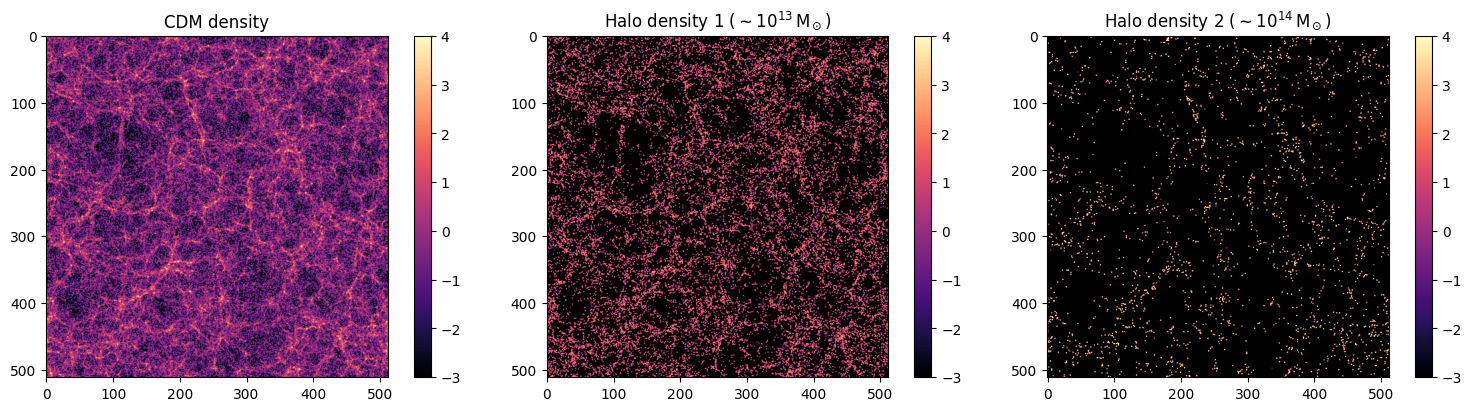

In [10]:
# Create a new figure
fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(15, 4))

# Plot the CDM density field
img1 = axs[0].imshow(np.log(1+delta[256-15:256+15].mean(axis=0)), cmap=cmap, vmin=-3, vmax=4)
axs[0].set_title("CDM density")
plt.colorbar(img1, ax=axs[0])

# Plot the halo density field
img2 = axs[1].imshow(np.log(1+halo_delta_1[256-15:256+15].mean(axis=0)), cmap=cmap, vmin=-3, vmax=4)
axs[1].set_title("Halo density 1 ($\\sim 10^{13}\\,\\mathrm{M_\\odot}$)")
plt.colorbar(img2, ax=axs[1])

# Plot the halo density field
img3 = axs[2].imshow(np.log(1+halo_delta_2[256-15:256+15].mean(axis=0)), cmap=cmap, vmin=-3, vmax=4)
axs[2].set_title("Halo density 2 ($\\sim 10^{14}\\,\\mathrm{M_\\odot}$)")
plt.colorbar(img3, ax=axs[2])

Next, we can compute the cross power spectrum. Pylians can simultaneously calculate the (auto) power spectra of fields $X$ and $Y$, along with the cross power spectrum between $X$ and $Y$.

In [11]:
# Compute the halo-CDM cross power spectrum
xPk_1 = PKL.XPk([delta, halo_delta_1], BoxSize, axis, MAS=['CIC', 'CIC'], threads=1)
xPk_2 = PKL.XPk([delta, halo_delta_2], BoxSize, axis, MAS=['CIC', 'CIC'], threads=1)

# Extract the auto and cross power spectra
k = xPk_1.k3D
Pk_c = xPk_1.Pk[:,0,0] # CDM power spectrum
Pk_h_1 = xPk_1.Pk[:,0,1] # Halo power spectrum (bin 1)
Pk_hc_1 = xPk_1.XPk[:,0,0] # Cross power spectrum (bin 1)
xNmodes = xPk_1.Nmodes3D

Pk_h_2 = xPk_2.Pk[:,0,1] # Halo power spectrum (bin 2)
Pk_hc_2 = xPk_2.XPk[:,0,0] # Cross power spectrum (bin 2)


Computing power spectra of the fields...
Time FFTS = 9.16
Time loop = 4.55
Time taken = 13.73 seconds

Computing power spectra of the fields...
Time FFTS = 9.17
Time loop = 4.55
Time taken = 13.74 seconds


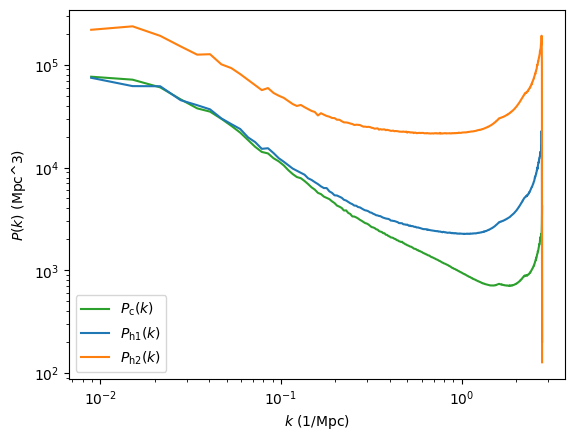

In [12]:
plt.loglog(k, Pk_c, label="$P_\\mathrm{c}(k)$", c="C2")
plt.loglog(k, Pk_h_1, label="$P_\\mathrm{h1}(k)$", c="C0")
plt.loglog(k, Pk_h_2, label="$P_\\mathrm{h2}(k)$", c="C1")
plt.xlabel("$k$ (1/Mpc)")
plt.ylabel("$P(k)$ (Mpc^3)")
plt.legend()

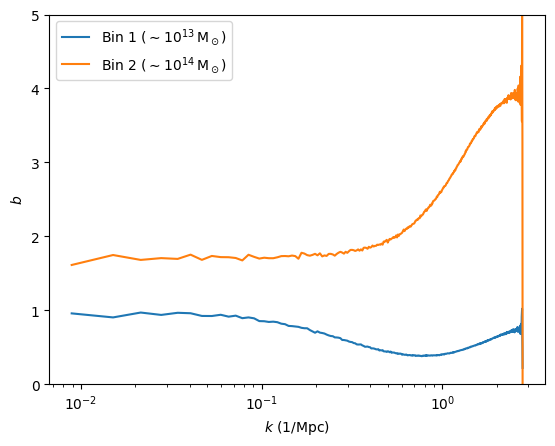

In [13]:
# Compute the halo bias for both mass bins
b_1 = Pk_hc_1 / Pk_c
b_2 = Pk_hc_2 / Pk_c

plt.semilogx(k, b_1, label="Bin 1 ($\\sim 10^{13}\\,\\mathrm{M_\\odot}$)", c="C0")
plt.semilogx(k, b_2, label="Bin 2 ($\\sim 10^{14}\\,\\mathrm{M_\\odot}$)", c="C1")
plt.xlabel("$k$ (1/Mpc)")
plt.ylabel("$b$")
plt.ylim((0,5))
plt.legend()

As expected, we find that the high-mass halos are more biased than the low-mass halos. Note also that the bias is only approximately constant on large scales (small $k$). On smaller scales, more complicated higher-order bias models are required to model the clustering of halos and galaxies.

## Cosmic voids
Cosmic voids are underdense regions in the cosmic web. There are many different definitions of voids and as many algorithms to identify them. Here, we will use a spherical overdensity void finder implemented in ``Pylians``. The algorithm works by smoothing the density field over a range of scales and identifying regions with a density contrast below a given threshold.

In [14]:
import void_library as VL

# Parameters of the void finder
threshold = -0.7
# Be careful not to set the lower radius too small, this will be very slow!
Radii = np.logspace(np.log10(10), np.log10(50), 10, dtype=np.float32) # Mpc
threads1 = 16
threads2 = 4

# We also want to compute a grid indicating all points inside voids
void_field = True

# Run the void finder
V = VL.void_finder(delta, BoxSize, threshold, Radii, threads1, threads2, void_field=void_field)
void_pos = V.void_pos.astype(np.float32) # void centres
void_radius = V.void_radius.astype(np.float32) # void radii
VSF_R = V.Rbins.astype(np.float32) # bins in radius for the void size function
VSF = V.void_vsf.astype(np.float32) # the void size function (number of voids/volume/dR)
if void_field:  void_field  = V.in_void.astype(np.float32)

maximum number of voids = 238732

Smoothing field with top-hat filter of radius 50.00
Density smoothing took 0.893 seconds
No cells with delta < -0.70

Smoothing field with top-hat filter of radius 41.81
Density smoothing took 0.880 seconds
Searching underdense cells took 0.087 seconds
Found 00001892 cells below threshold
Sorting took 0.000 seconds
Mode = 0    :   Ncells = 22   :   threads = 4
Found 000002 voids with radius R =41.813 Mpc/h
Found 000002 voids with radius R>=41.813 Mpc/h
Void volume filling fraction = 6.133e-04
Expected    filling fraction = 6.124e-04
Time1 = 0.000 seconds
Time2 = 0.003 seconds
void finding took 0.053 seconds

Smoothing field with top-hat filter of radius 34.97
Density smoothing took 0.887 seconds
Searching underdense cells took 0.095 seconds
Found 00015155 cells below threshold
Sorting took 0.001 seconds
Mode = 0    :   Ncells = 18   :   threads = 4
Found 000031 voids with radius R =34.966 Mpc/h
Found 000033 voids with radius R>=34.966 Mpc/h
Void volume

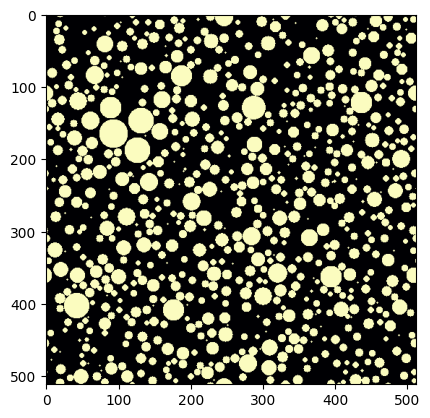

In [15]:
# Plot the void field
plt.imshow(void_field[256], cmap="magma")

The analogue of the halo mass function for cosmic voids is the **void size function**.

Text(0, 0.5, '$\\mathrm{d} N/V/\\mathrm{d}R$')

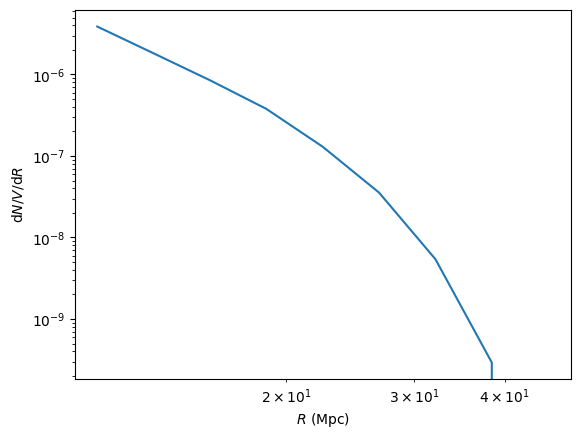

In [16]:
# Plot the void size function
plt.loglog(VSF_R, VSF)
plt.xlabel("$R$ (Mpc)")
plt.ylabel("$\\mathrm{d} N/V/\\mathrm{d}R$")

## Exercise
Compute the void bias for different bins of void radius, using the definition

$$b_\mathrm{v}(k) = \frac{P_\mathrm{cv}(k)}{P_\mathrm{c}(k)}.$$

How does the bias depend on void size?

*Hint: For this purpose, you will need the void number density field, which only takes the void centres as input. This is different from the void field generated above, which marks all points inside voids.*

## Answer

## Expectation from the literature
From Chan, Hamaus, and Desjacques (2014), PRD, 90, 103521 (2014)
![alt text](void_bias.png "Expected void bias for different radii.")


*Note: The axis label in this figure refers to $b_c$, but this is what we call $b_\mathrm{v}$.*

## Takeaways
* Pylians is a useful library for large-scale structure studies, but there are many others
* The power spectrum is a powerful diagnostic, corresponding to the Fourier transform of the correlation function
* Galaxies, halos, and voids are examples of biased tracers of the dark matter field